# **COVID-19 Twitter Sentiment Analysis**

## **Goal of Analysis**

We'll use the following notebook to do sentiment analysis on a set of tweets concerning the Covid-19 vaccination:

 - Pfizer/BioNTech
 - Sinopharm
 - Sinovac
 - Moderna
 - Oxford/AstraZeneca
 - Covaxin
 - Sputnik V.
   

[*The Data*](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets?select=vaccination_all_tweets.csv)

The tweets are then tagged as either positive (i.e. vaccine is safe!) or negative (i.e. don't get the vaccination) We'll wrap off this article by looking at the terms that are most indicative of a positive or negative tweet.

In [3]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
from textblob import TextBlob


<br>

## **1. Preprocessing**

### **1.1 Cleaning the Data**

In [4]:

df = pd.read_csv('vaccination_all_tweets.csv', low_memory=False)
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [5]:


#dropping the extra columns
df = df.drop(['user_location', 'id', 'user_description', 'hashtags', 'is_retweet', 'user_created','source', 'user_verified'], axis =1)

df.head()

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites
0,Rachel Roh,405,1692,3247,2020-12-20 6:06,Same folks said daikon paste could treat a cyt...,0,0
1,Albert Fong,834,666,178,2020-12-13 16:27,While the world has been on the wrong side of ...,1,1
2,eli🇱🇹🇪🇺👌,10,88,155,2020-12-12 20:33,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,0,0
3,Charles Adler,49165,3933,21853,2020-12-12 20:23,"Facts are immutable, Senator, even when you're...",446,2129
4,Citizen News Channel,152,580,1473,2020-12-12 20:17,Explain to me again why we need a vaccine @Bor...,0,0


<br>

There are a lot of non-text symbols in our Covid-19 twitter dataset because it's made up of Tweets. This will simply help to confuse our algorithms and reduce the accuracy of sentiment forecasts. As a result, we chose to remove such symbols in order to create a simpler and perhaps more accurate model.

#### **Symbols to be removed.**
 - url symbols (http:)
 - Twitter symbols (@, #)

In [6]:
from sklearn.model_selection import train_test_split

def standardize_text(df, text_field):
    #removes special strings and non text
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_covid.csv')
df.head()

<ipython-input-6-bfbb1ffde4a7>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
<ipython-input-6-bfbb1ffde4a7>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
<ipython-input-6-bfbb1ffde4a7>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")


,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites
0,Rachel Roh,405,1692,3247,2020-12-20 6:06,same folks said daikon paste could treat a cyt...,0,0
1,Albert Fong,834,666,178,2020-12-13 16:27,while the world has been on the wrong side of ...,1,1
2,eli🇱🇹🇪🇺👌,10,88,155,2020-12-12 20:33,coronavirus sputnikv astrazeneca pfizerbio...,0,0
3,Charles Adler,49165,3933,21853,2020-12-12 20:23,"facts are immutable, senator, even when you're...",446,2129
4,Citizen News Channel,152,580,1473,2020-12-12 20:17,explain to me again why we need a vaccine w...,0,0


<br>

### **1.2 Data Tokenization**
Here we turn our twitter strings to lists of individual tokens. (words, punctuations)

In [7]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites,tokens
0,Rachel Roh,405,1692,3247,2020-12-20 6:06,same folks said daikon paste could treat a cyt...,0,0,"[same, folks, said, daikon, paste, could, trea..."
1,Albert Fong,834,666,178,2020-12-13 16:27,while the world has been on the wrong side of ...,1,1,"[while, the, world, has, been, on, the, wrong,..."
2,eli🇱🇹🇪🇺👌,10,88,155,2020-12-12 20:33,coronavirus sputnikv astrazeneca pfizerbio...,0,0,"[coronavirus, sputnikv, astrazeneca, pfizerbio..."
3,Charles Adler,49165,3933,21853,2020-12-12 20:23,"facts are immutable, senator, even when you're...",446,2129,"[facts, are, immutable, senator, even, when, y..."
4,Citizen News Channel,152,580,1473,2020-12-12 20:17,explain to me again why we need a vaccine w...,0,0,"[explain, to, me, again, why, we, need, a, vac..."


<br>

#### Tweet Sentiment
 - Positive Sentiment = 1
 - Negative Sentiment = 0
 
#### Polarity
 - Range of [0,1] describing the positivity of the assignment.
 
#### Text
 - Text composition of the tweet

In [8]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def S_analyze(coool):
    score = SentimentIntensityAnalyzer().polarity_scores(coool)
    neg = score['neg']
    pos = score['pos']
    if neg < pos:
        return 1
    else:
        return 0
        

df['sentiment'] = df['text'].apply(S_analyze)
df['polarity']  = df['text'].apply(getPolarity)


### **1.2.1 Sentence Length and Vocabulary Size**

We have a vocabulary of 46291 distinct words with an average sentence length of 15-17 words.

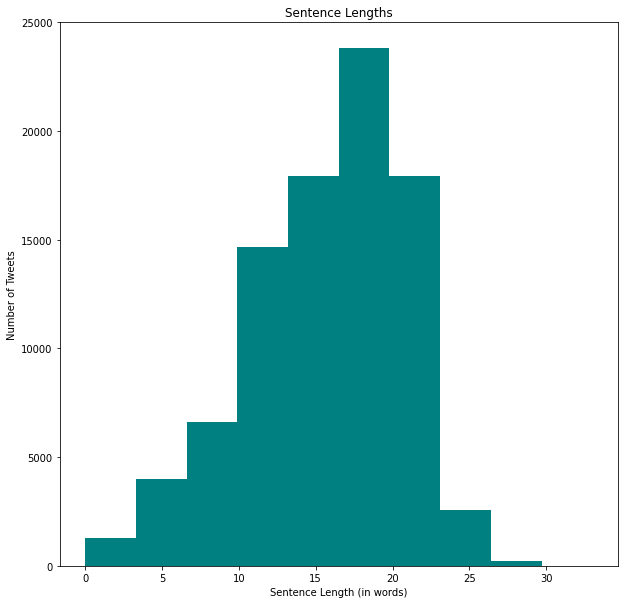

In [9]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens])))

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths, color="teal")
plt.show()

In [10]:
df.head(20)

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites,tokens,sentiment,polarity
0,Rachel Roh,405,1692,3247,2020-12-20 6:06,same folks said daikon paste could treat a cyt...,0,0,"[same, folks, said, daikon, paste, could, trea...",1,0.000000
1,Albert Fong,834,666,178,2020-12-13 16:27,while the world has been on the wrong side of ...,1,1,"[while, the, world, has, been, on, the, wrong,...",0,-0.500000
2,eli🇱🇹🇪🇺👌,10,88,155,2020-12-12 20:33,coronavirus sputnikv astrazeneca pfizerbio...,0,0,"[coronavirus, sputnikv, astrazeneca, pfizerbio...",1,0.000000
3,Charles Adler,49165,3933,21853,2020-12-12 20:23,"facts are immutable, senator, even when you're...",446,2129,"[facts, are, immutable, senator, even, when, y...",0,-0.050000
4,Citizen News Channel,152,580,1473,2020-12-12 20:17,explain to me again why we need a vaccine w...,0,0,"[explain, to, me, again, why, we, need, a, vac...",0,0.000000
5,Dee,105,108,106,2020-12-12 20:11,does anyone have any useful advice guidance fo...,0,0,"[does, anyone, have, any, useful, advice, guid...",1,0.400000
6,Gunther Fehlinger,2731,5001,69344,2020-12-12 20:06,it is a bit sad to claim the fame for success ...,0,4,"[it, is, a, bit, sad, to, claim, the, fame, fo...",1,-0.100000
7,Dr.Krutika Kuppalli,21924,593,7815,2020-12-12 20:04,there have not been many bright days in 2020 b...,2,22,"[there, have, not, been, many, bright, days, i...",1,0.675000
8,Erin Despas,887,1515,9639,2020-12-12 20:01,covid vaccine you getting it?\n\n covidvacci...,2,1,"[covid, vaccine, you, getting, it, covidvaccin...",0,0.000000
9,Ch.Amjad Ali,671,2368,20469,2020-12-12 19:30,covidvaccine \n\nstates will start getting c...,0,0,"[covidvaccine, states, will, start, getting, c...",0,0.000000


In [11]:
print('Words in vocab: ', len(vocab))

Words in vocab:  46291


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df[['text', 'polarity']]
y = df['sentiment']

#splitting data for cross validation of model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,shuffle=False)

#Keeping the assignment confidence for later
X_train_conf, X_test_conf = X_train['polarity'], X_test['polarity']
X_train, X_test = X_train['text'], X_test['text']

#saving to csv
X_train.to_csv('train_clean.csv')
X_test.to_csv('test_clean.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

print(X_train[:10])

0    same folks said daikon paste could treat a cyt...
1    while the world has been on the wrong side of ...
2     coronavirus  sputnikv  astrazeneca  pfizerbio...
3    facts are immutable, senator, even when you're...
4    explain to me again why we need a vaccine    w...
5    does anyone have any useful advice guidance fo...
6    it is a bit sad to claim the fame for success ...
7    there have not been many bright days in 2020 b...
8    covid vaccine  you getting it?\n\n  covidvacci...
9     covidvaccine \n\nstates will start getting  c...
Name: text, dtype: object


In [14]:
#vectorization with TFIDF and scikit learn
vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)


#sparse matrix rows << columns
X_train_tfidf[0]

<1x40492 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

<br>

To reduce our dataset to two dimensions, we apply a singular value decomposition. This will allow us to evaluate if the data has any intrinsic linear separability that our model may exploit.

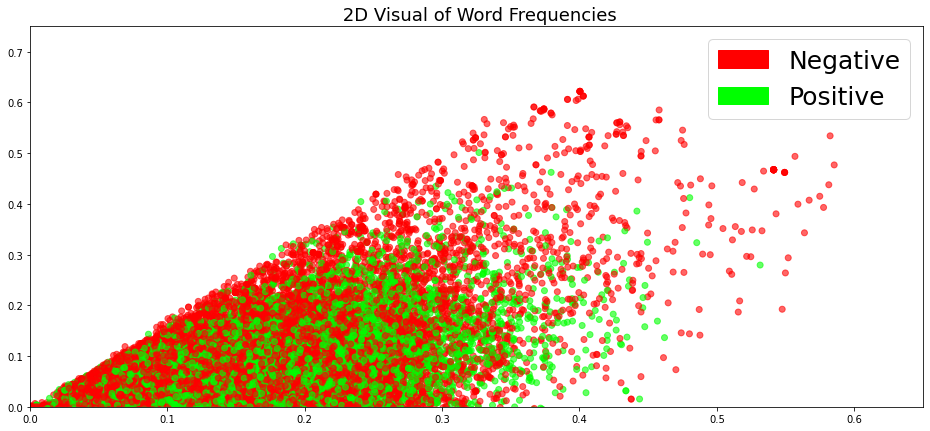

In [12]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_lsa(text, labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(text)
    lsa_scores = lsa.transform(text)
    color_dict = {label:idx for idx, label in enumerate(set(labels))}
    color_column = [color_dict[label] for label in labels]
    colors = ['red', 'lime']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1],alpha=0.6, c = labels, cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='red', label='Negative')
        green_patch = mpatches.Patch(color='lime', label='Positive')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 25})

fig = plt.figure(figsize =(16,7))
plot_lsa(X_train_tfidf, y_train)
plt.xlim(0,0.65)
plt.ylim(0,0.75)
plt.title(" 2D Visual of Word Frequencies", size = 18)
plt.show()

No conclusive result but 117888 negative words as to 6008 positive words

<br>

## **2. Confusion Matrix**

### **2.1 Model Build**

Rather than false positives, our model prefers to produce false negatives. Below are some examples of tweets that have been misclassified.

In [30]:
from sklearn.linear_model import LogisticRegressionCV

logr = LogisticRegressionCV(max_iter=100000)
logr.fit(X_train_tfidf, y_train)
y_pred_logr = logr.predict(X_test_tfidf)

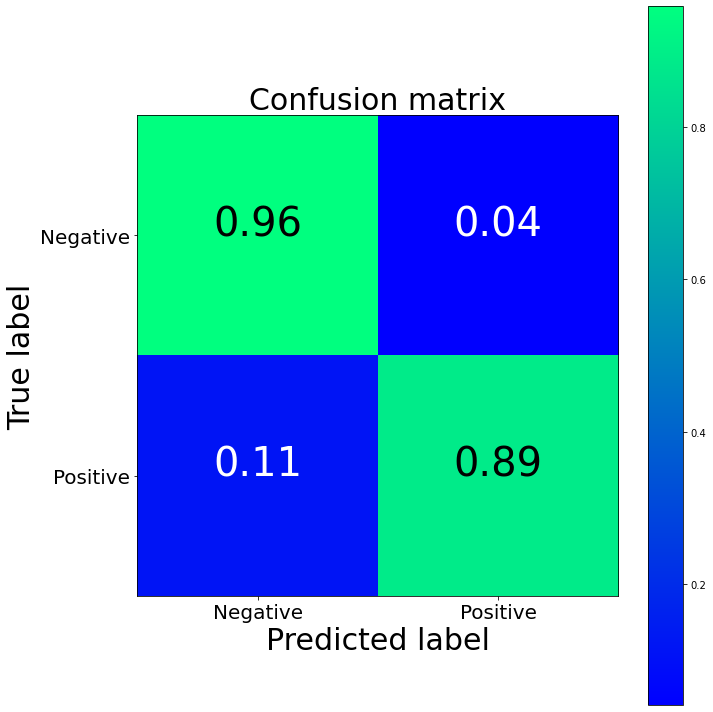

[[11072   475]
 [  716  5533]]


In [39]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    return plt

cm = confusion_matrix(y_test, y_pred_logr)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=True, title='Confusion matrix')
plt.show()
print(cm)

### **Examples of False Negatives (Predicted Neg/Actual Pos)**

In [26]:
def find_fn(ypred, ytrue):
    y_fn  = X_test[(ypred==0)&(ypred!=ytrue)]
    return y_fn

fn = find_fn(y_pred_logr, y_test)
print('Number of False Negatives: ', fn.shape, '\n')
print(fn[:1].values, '\n')
print(fn[1:2].values, '\n')
print(fn[2:3].values, '\n')
print(fn[3:4].values)

Number of False Negatives:  (716,) 

['today my grandma, 94 years old, had her 2nd jab  moderna , in her traditional  sardiniandress   bravery, stamina, h  '] 

['first shot received! yippee!! dolly would never steer you wrong       get out and get vaccinated      \n teammoderna  '] 

['i received my first  covid_19  vaccination today! feeling  blessedandgrateful    moderna'] 

['i m fully vaccinated as of 10 05am this morning  though i ve felt comfortable not wearing my face covering more and  ']


### **Examples of False Positives (Predicted Pos/ Actual Neg)**

In [27]:
def find_fp(ypred, ytrue):
    y_fp  = X_test[(ypred==1)&(ypred!=ytrue)]
    return y_fp

fp = find_fp(y_pred_logr, y_test)
print('Number of False Positives: ', fp.shape, '\n')
print(fp[:1].values, '\n')
print(fp[1:2].values, '\n')
print(fp[2:3].values, '\n')
print(fp[3:4].values)

Number of False Positives:  (475,) 

["needles to say she didn't laugh  she clearly has developed strong immunity to my puns by now \n \n\n \n vaccine  "] 

[" just got my second shot! i'm sitting here listening to muzak and texting friends   already dreading  "] 

["shot 1 is done  and from the sounds of it, i'm not going to enjoy shot 2   covidvaccine  moderna  getvaccinated"] 

['feeling giddy  first vaccine received!  covidvaccination  moderna  vaccinated']


In [31]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(vect, logr, 10)

## **3. Word Importances**

Our model clearly picks up on phrases that might indicate a positive or negative tweet, as shown in the graphic below. Another important point to note is that the phrases "killing" and "cancer" both have a strong negative connotation. Perhaps these Twitter users feel Covid-19 vaccine dangerous?



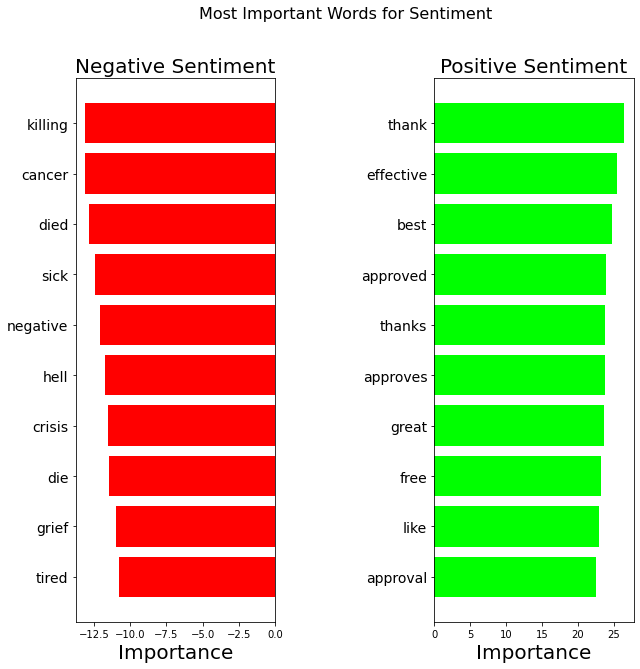

In [40]:
import numpy as np
import itertools

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=1, color="red")
    plt.title('Negative Sentiment', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=1, color="lime")
    plt.title('Positive Sentiment', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most Important Words for Sentiment")

It's also worth noting that the words "thank" and "effective" have a strong positive meaning. probably shows a sense of gratefulness of the public.

In [77]:
column = df["user_followers"]
column2 = df["favorites"]
column3 = df["retweets"]

max_value = column.max()
max_value2 = column2.max()
max_value3= column3.max()

print("User followers:")     
print(max_value)

print("Favorites:")
print(max_value2)

print("retweets")     
print(max_value3)

User followers:
15569502
Favorites:
25724
retweets
11288


**The user (NDTV) with the most followers makes a neutral  statement to the public and isn't overly exposed.**

In [86]:

df.loc[df['user_followers'] == max_value]

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites,tokens,sentiment,polarity
88669,NDTV,15569502,15,0,2021-05-26 8:55,"covid19 ""talks are on with them their peop...",10,99,"[covid19, talks, are, on, with, them, their, p...",0,0.0


**The user with the most likes and retweets makes a positive statement to the public.**

In [67]:

df.loc[df['favorites'] == max_value2]

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites,tokens,sentiment,polarity
68358,Sputnik V,341843,142,1069,2021-04-20 15:30,"rdif, laboratorios richmond launched productio...",11288,25724,"[rdif, laboratorios, richmond, launched, produ...",1,0.25


In [79]:
df.loc[df['retweets'] == max_value3]

,user_name,user_followers,user_friends,user_favourites,date,text,retweets,favorites,tokens,sentiment,polarity
68358,Sputnik V,341843,142,1069,2021-04-20 15:30,"rdif, laboratorios richmond launched productio...",11288,25724,"[rdif, laboratorios, richmond, launched, produ...",1,0.25


Most used works in the comments:

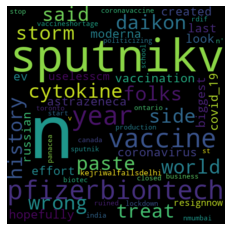

In [84]:
from wordcloud import WordCloud

text = df['text'].values
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0).generate(str(text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<br>

## **Conclusion**

we have found according to [*the data*](https://www.kaggle.com/gpreda/all-covid19-vaccines-tweets?select=vaccination_all_tweets.csv), we've noticed a rise in anti-vaccine sentiment, particularly in the case of the Sputnikv vaccination.